# L Curve Demonstration

In [1]:
from drt_solver.device import DRT, Measurement
from drt_solver.simulation import Simulation
import jax.numpy as jnp 
import pandas as pd

from fitting.optimizer import Optimizer
import matplotlib.pyplot as plt

from drt_solver_old.database import (ZARC, 
                                 gamma_ZARC)

ModuleNotFoundError: No module named 'drt_solver'

### 1. Upload Measurement Data

In [2]:
columns = ["f", "Z_re", "Z_im"]
df = pd.read_csv("/Users/tara/Downloads/1_15ml_100mM_DHPS_10_PEIS_C01_EIS_data.csv", header=None, names=columns)

f = jnp.array(df["f"].values)
tau = jnp.flip(jnp.logspace(-6, 6, 100))
#tau = 1./(2*jnp.pi*f)

Z_exact_re =  jnp.array(df["Z_re"].values)
Z_exact_im =  jnp.array(df["Z_im"].values)

# Create our measurement object
measurement = Measurement(Z_exact_re, Z_exact_im, f)

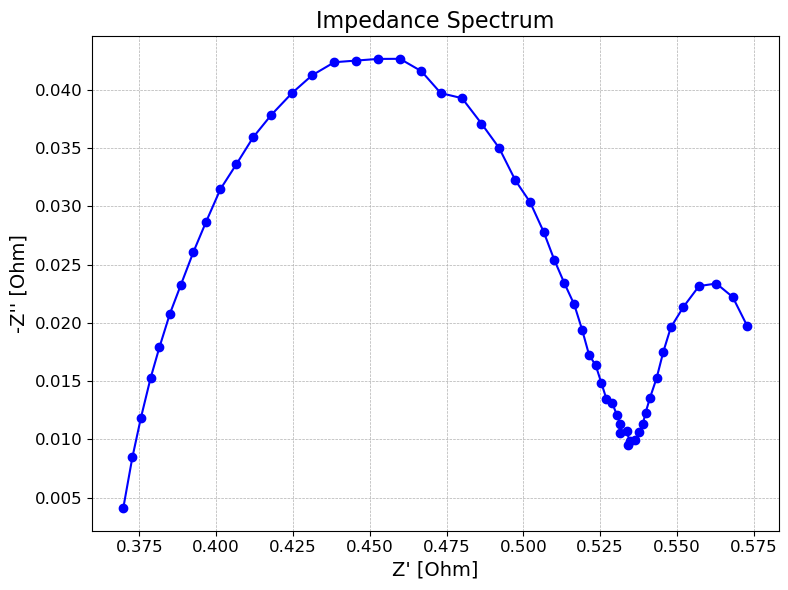

In [3]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(Z_exact_re, -Z_exact_im, label='Impedance Spectrum', color='blue', marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Z\' [Ohm]', fontsize=14)
plt.ylabel('-Z\'\' [Ohm]', fontsize=14)
plt.title('Impedance Spectrum', fontsize=16)

# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### 2. Initial Guess 

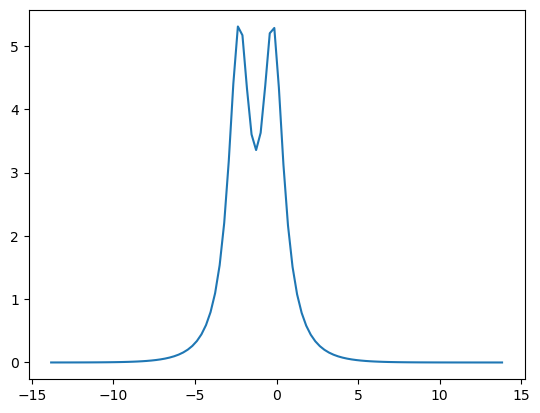

In [4]:
gamma_guess2 = gamma_ZARC(tau,  R_ct=10, tau_0=.1, phi= .8) + gamma_ZARC(tau,  R_ct=10, tau_0=.8, phi= .8)
plt.plot(jnp.log(tau), gamma_guess2)

drt_guess = DRT(R_inf=50, L_0=0, gamma=gamma_guess2, tau=tau)

### 3. Create Lambda Values 

In [5]:
lbd_vals = jnp.linspace(0.0, .3, 10)


In [6]:
loss_vals = []
for lbd in lbd_vals: 
    print("Lambda Val: ", lbd)
    solver_dict = {'lambda': lbd, 'maxiter': 50000}
    optim = Optimizer(drt=drt_guess, measurement=measurement, solver="regression", solver_dict = solver_dict)
    final_sim = optim.run()
    drt_final = DRT(final_sim.R_inf, final_sim.L_0, final_sim.drt, final_sim.tau)
    loss_vals.append(final_sim.value)


Lambda Val:  0.0
Lambda Val:  0.03333333333333333
Lambda Val:  0.06666666666666667
Lambda Val:  0.1
Lambda Val:  0.13333333333333333
Lambda Val:  0.16666666666666666
Lambda Val:  0.2
Lambda Val:  0.23333333333333334
Lambda Val:  0.26666666666666666
Lambda Val:  0.3


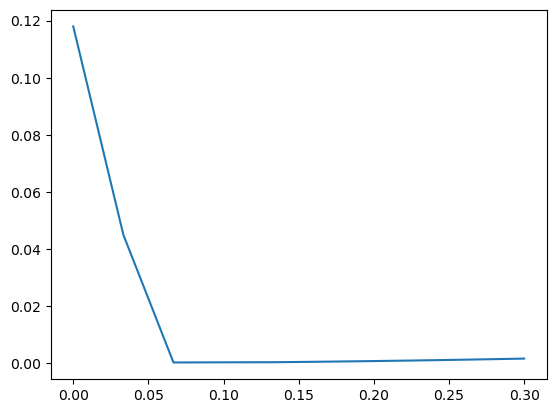

In [7]:
plt.plot(lbd_vals, loss_vals)
plt.show()

### Optimal Value of Lambda Implementation 

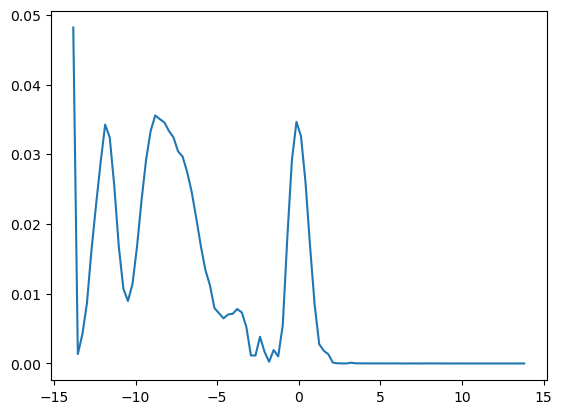

In [8]:
solver_dict = {'lambda': 0.1, 'maxiter': 80000}
optim = Optimizer(drt=drt_guess, measurement=measurement, solver="regression", solver_dict = solver_dict)
final_sim = optim.run()
drt_final = DRT(final_sim.R_inf, final_sim.L_0, final_sim.drt, final_sim.tau)
simulation_final = Simulation(drt_final, f)

plt.plot(jnp.log(drt_final.tau), drt_final.gamma)
plt.show()


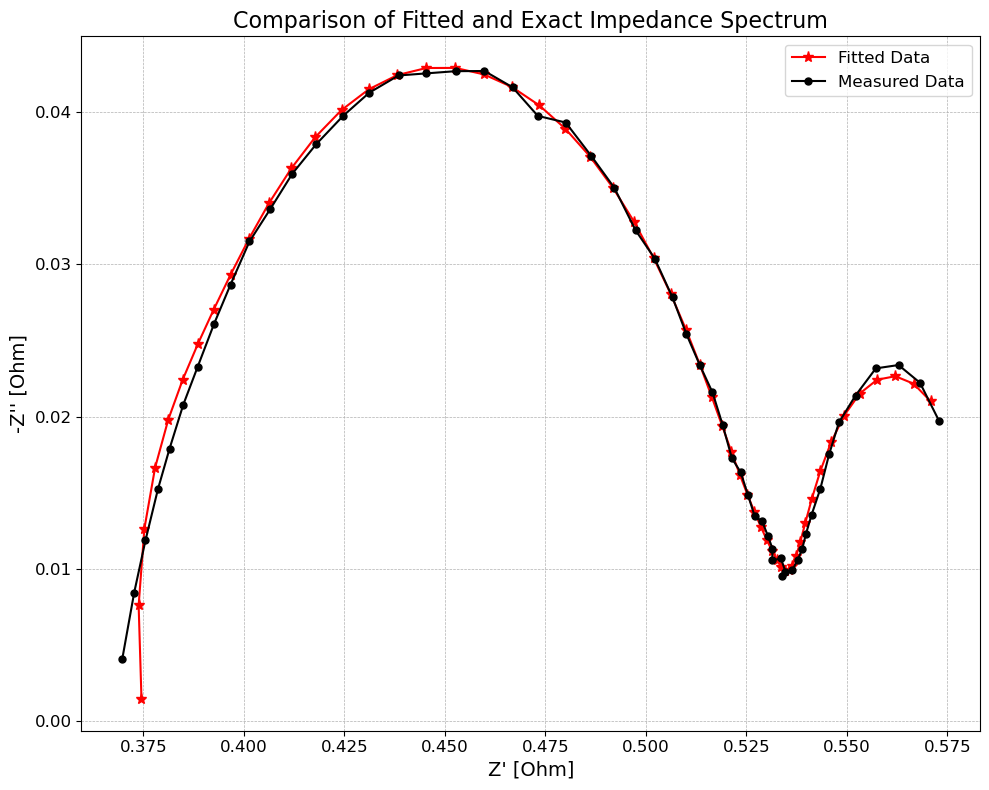

In [9]:
Z_re, Z_im = simulation_final.run()

# Create the plot
plt.figure(figsize=(10, 8))

# Plot the data
plt.plot(Z_re, -Z_im, '-r*', label='Fitted Data', markersize=8)
plt.plot(Z_exact_re, -Z_exact_im, '-ko', label='Measured Data', markersize=5, linewidth=1.5)

# Add labels and title
plt.xlabel('Z\' [Ohm]', fontsize=14)
plt.ylabel('-Z\'\' [Ohm]', fontsize=14)
plt.title('Comparison of Fitted and Exact Impedance Spectrum', fontsize=16)

# Add a legend
plt.legend(loc='best', fontsize=12)

# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()